# Logit Lens Investigation

Investigating how the Pythia 160m model represents knowledge from pre-training, using a prompt intended to generate a token for Dublin as the capital of Ireland. This is based on the **logit lens** technique: applying the unembedding to intermediate residuals to see what the model would predict at each layer. This is the smallest model which behaves like this.

In [1]:
# Install dependencies and set up the package
# %pip install transformers torch matplotlib

# Install the local package in development mode
import sys
sys.path.insert(0, '../src')

In [2]:
from transformer_algebra import LogitLens, load_pythia_model

# Load Pythia-160m-deduped from HuggingFace
model, tokenizer = load_pythia_model("EleutherAI/pythia-160m-deduped")
lens = LogitLens(model, tokenizer)

print(f"Model: {model.config.name_or_path}")
print(f"Layers: {model.config.num_hidden_layers}")
print(f"Heads: {model.config.num_attention_heads}")
print(f"d_model: {model.config.hidden_size}")

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Model: EleutherAI/pythia-160m-deduped
Layers: 12
Heads: 12
d_model: 768


In [3]:
# Our test prompt
prompt = "The capital of Ireland is"
token_info = lens.tokenize(prompt)
print(f"Tokens: {token_info.str_tokens}")
print(f"Token IDs: {token_info.token_ids}")

Tokens: ['The', ' capital', ' of', ' Ireland', ' is']
Token IDs: [510, 5347, 273, 11011, 310]


In [4]:
# Get the token ID for "Dublin" (with leading space)
dublin_token = lens.get_token_id(" Dublin")
print(f"' Dublin' token ID: {dublin_token} = '{tokenizer.decode([dublin_token])}'")

' Dublin' token ID: 24523 = ' Dublin'


In [72]:
# Analyze: logit lens for "Dublin" across all layers
result = lens.analyze(prompt, " Dublin")
result.print_report()

Logit for ' Dublin' at each layer:
  After embedding: +219.88
  After block 1: +184.57
  After block 2: +194.04
  After block 3: +196.86
  After block 4: +204.84
  After block 5: +200.17
  After block 6: +200.77
  After block 7: +216.13
  After block 8: +222.88
  After block 9: +249.70
  After block 10: +235.54
  After block 11: +304.55
  After block 12: +786.74

Top 5 predictions after final layer:
  1. ' the' (logit: 786.61)
  2. ' a' (logit: 784.93)
  3. ' Belfast' (logit: 784.57)
  4. ' Dublin' (logit: 784.47)
  5. ' now' (logit: 784.44)


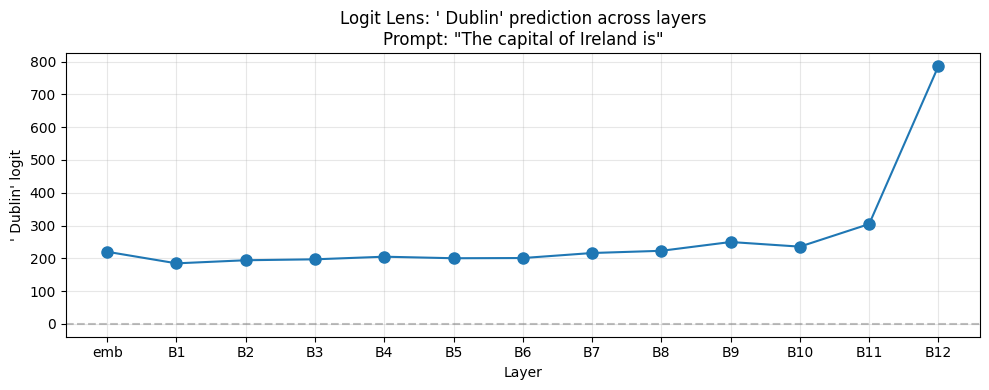

In [73]:
# Visualize the logit lens
lens.plot_logits(result, prompt)

Dublin is in the top 5 tokens, but Belfast is higher.

## Experiment 2: Framing Clause

A framing clause is added to the sentence to try and influence the model's prediction.

In [5]:
prompt2 = "Now children, as we know, the capital of Ireland is"
token_info2 = lens.tokenize(prompt2)
print(f"Tokens: {token_info2.str_tokens}")
print(f"Token IDs: {token_info2.token_ids}")

Tokens: ['Now', ' children', ',', ' as', ' we', ' know', ',', ' the', ' capital', ' of', ' Ireland', ' is']
Token IDs: [4125, 2151, 13, 347, 359, 871, 13, 253, 5347, 273, 11011, 310]


In [ ]:
result2 = lens.analyze(prompt2, " Dublin")
result2.print_report()

Logit for ' Dublin' at each layer:
  After embedding: +219.88
  After block 1: +175.46
  After block 2: +190.72
  After block 3: +186.87
  After block 4: +194.52
  After block 5: +196.56
  After block 6: +197.45
  After block 7: +213.46
  After block 8: +221.73
  After block 9: +246.20
  After block 10: +230.04
  After block 11: +301.50
  After block 12: +786.32

Top 5 predictions after final layer:
  1. ' the' (logit: 786.42)
  2. ' in' (logit: 784.41)
  3. ' to' (logit: 784.20)
  4. ' a' (logit: 784.15)
  5. ' now' (logit: 784.11)


In [ ]:
# Debugging the discrepancy: compare logit lens final layer vs model output
import torch

# Get hidden states for prompt2
hidden_states, outputs = lens.get_hidden_states(prompt2)

# Logit lens approach: apply final_ln then unembed
final_hidden = hidden_states[-1][0, -1, :]  # Last layer, last position
logit_lens_normed = lens.final_ln(final_hidden)
logit_lens_logits = lens.unembed(logit_lens_normed)

# Model's actual output
model_logits = outputs.logits[0, -1, :]

# Compare Dublin logit
dublin_id = lens.get_token_id(" Dublin")
print(f"Dublin logit (logit lens): {logit_lens_logits[dublin_id].item():.2f}")
print(f"Dublin logit (model output): {model_logits[dublin_id].item():.2f}")
print()

# Check if they're the same tensor
print(f"Are logits close? {torch.allclose(logit_lens_logits, model_logits)}")
print(f"Max difference: {(logit_lens_logits - model_logits).abs().max().item():.6f}")
print()

# Top 5 from each
print("Top 5 from logit lens:")
top5_lens = torch.topk(logit_lens_logits, 5)
for logit, tok_id in zip(top5_lens.values, top5_lens.indices):
    print(f"  '{tokenizer.decode([tok_id.item()])}': {logit.item():.2f}")

print("\nTop 5 from model output:")
top5_model = torch.topk(model_logits, 5)
for logit, tok_id in zip(top5_model.values, top5_model.indices):
    print(f"  '{tokenizer.decode([tok_id.item()])}': {logit.item():.2f}")

Dublin logit (logit lens): 786.32
Dublin logit (model output): 784.04

Are logits close? False
Max difference: 7.594055

Top 5 from logit lens:
  ' the': 790.00
  ' in': 789.06
  ' a': 788.39
  ' to': 788.29
  ',': 788.26

Top 5 from model output:
  ' the': 786.42
  ' in': 784.41
  ' to': 784.20
  ' a': 784.15
  ' now': 784.11


## Notes

**Discrepancy explained:** The original code had a bug where:
- `logits_by_layer` was computed via logit lens: `final_ln(hidden_states[-1])` → `unembed`
- `top_predictions` came from `outputs.logits` (the model's actual output)

These differ by up to ~7.6 logits due to precision/fusion differences in the model's forward pass. 
The fix ensures both use the same logit lens computation for consistency.

In [6]:
# Reload the module to pick up the fix
import importlib
import transformer_algebra
import transformer_algebra.logit_lens
importlib.reload(transformer_algebra.logit_lens)
importlib.reload(transformer_algebra)
from transformer_algebra.logit_lens import LogitLens

# Recreate lens and re-run
lens = LogitLens(model, tokenizer)
result2_fixed = lens.analyze(prompt2, " Dublin")
result2_fixed.print_report()

Logit for ' Dublin' at each layer:
  After embedding: +219.88
  After block 1: +175.46
  After block 2: +190.72
  After block 3: +186.87
  After block 4: +194.52
  After block 5: +196.56
  After block 6: +197.45
  After block 7: +213.46
  After block 8: +221.73
  After block 9: +246.20
  After block 10: +230.04
  After block 11: +301.50
  After block 12: +786.32

Top 5 predictions after final layer:
  1. ' the' (logit: 790.00)
  2. ' in' (logit: 789.06)
  3. ' a' (logit: 788.39)
  4. ' to' (logit: 788.29)
  5. ',' (logit: 788.26)
